### Creating a LSTM Model

In [159]:
from pymongo import MongoClient
import numpy as np
import os
import random
import tensorflow as tf
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
%matplotlib inline
tqdm.pandas()

In [137]:
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import LSTM , Dense , Flatten , Dropout , Input
from tensorflow.keras.callbacks import TensorBoard , EarlyStopping

In [138]:

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [170]:
actions = np.array(['hello' , 'thankyou' , 'iloveyou'])

# Creating Label Map 

label_map = {label:num for num , label in enumerate(actions)}

In [171]:
label_map

{'hello': 0, 'thankyou': 1, 'iloveyou': 2}

In [140]:
tf.random.set_seed(17)
np.random.seed(17)
random.seed(17)

#### 1. Extracting Data from MongoDB

In [141]:
connection = MongoClient('localhost' , 27017)
db = connection['mydb']
collection = db['Preprocessed_Landmark_Data']

In [142]:
cursor = collection.find({})
df = pd.DataFrame(list(cursor))

In [143]:
df['Landmarks'] = df['Landmarks'].progress_apply(lambda landmarks : [np.array(x) if isinstance(x , list) else x for x in landmarks])

100%|██████████| 90/90 [00:00<00:00, 415.90it/s]


In [144]:
df['Landmarks'][0]

[array([ 0.48065224,  0.49961472, -2.0412364 , ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.548204  ,  0.49962679, -1.46068573, ...,  0.32158235,
         0.4842366 , -0.02871111]),
 array([ 0.56474423,  0.49930447, -1.46504617, ...,  0.29121   ,
         0.53220797, -0.00797502]),
 array([ 0.55826348,  0.49939868, -1.63277209, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.55256563,  0.49950689, -1.56892347, ...,  0.3097041 ,
         0.82298547, -0.00171271]),
 array([ 0.55288625,  0.4994345 , -1.61392653, ...,  0.3425214 ,
         0.95327604, -0.04101617]),
 array([ 0.55006087,  0.49920294, -1.5357002 , ...,  0.3447842 ,
         0.9435519 , -0.04059755]),
 array([ 0.54760826,  0.49683374, -1.53707707, ...,  0.33501303,
         0.91033256, -0.03627473]),
 array([ 0.54662049,  0.49504429, -1.51402426, ...,  0.33440495,
         0.90888566, -0.03550041]),
 array([ 0.54551339,  0.4950456 , -1.57081664, ...,  0.33054742,
         0.75952172, -0.01

In [145]:
X = np.array(df['Landmarks'].tolist())
labels_list = (df['Labels'].tolist())
y = to_categorical(labels_list).astype(int)


In [146]:
X.shape

(90, 30, 1662)

In [147]:
y.shape

(90, 3)

In [148]:
X

array([[[ 4.80652243e-01,  4.99614716e-01, -2.04123640e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.48204005e-01,  4.99626786e-01, -1.46068573e+00, ...,
          3.21582347e-01,  4.84236598e-01, -2.87111141e-02],
        [ 5.64744234e-01,  4.99304473e-01, -1.46504617e+00, ...,
          2.91209996e-01,  5.32207966e-01, -7.97502417e-03],
        ...,
        [ 5.62077880e-01,  4.74422544e-01, -1.39941478e+00, ...,
          3.78414989e-02,  1.30787849e-01, -7.36482963e-02],
        [ 5.62012374e-01,  4.75472271e-01, -1.55177093e+00, ...,
          3.96431163e-02,  1.31247073e-01, -7.80704245e-02],
        [ 5.61469734e-01,  4.75749224e-01, -1.52884209e+00, ...,
          9.81486738e-02,  1.65311962e-01, -7.16133490e-02]],

       [[ 5.58134079e-01,  4.74364877e-01, -1.37350905e+00, ...,
          1.29088789e-01,  1.94955125e-01, -5.59374504e-02],
        [ 5.57600141e-01,  4.89600807e-01, -1.60779452e+00, ...,
          3.83548439e-01,  3.54468614e

#### 2. Performing Train-test split
- using 95-5  percent train-test split

In [149]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.05)

In [150]:
print("X-train shape:" , X_train.shape)
print("X-test shape:" , X_test.shape)
print("y-train shape:" , y_train.shape)
print("y-test shape:" , X_test.shape)

X-train shape: (85, 30, 1662)
X-test shape: (5, 30, 1662)
y-train shape: (85, 3)
y-test shape: (5, 30, 1662)


Creating LSTM Model Architecture

In [151]:
# Creating a Instance of Early Stopping

early_stopping_callback = EarlyStopping(
 monitor = 'val_loss',
 patience = 5,
 mode = 'min',
 restore_best_weights = True
)

In [152]:
X_train.shape

(85, 30, 1662)

In [153]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [154]:
# Constructing LSTM Model

LSTM_model = Sequential()
LSTM_model.add(LSTM(64, return_sequences= True , activation = 'relu' , input_shape = (30 , 1662)))
LSTM_model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
# model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
LSTM_model.add(LSTM(64 , return_sequences= False , activation='relu'))
# model.add(Dense(128 , activation ='relu'))
# model.add(Dense(64 , activation ='relu'))
LSTM_model.add(Dense(64 , activation ='relu'))
LSTM_model.add(Dense(32 , activation = 'relu'))
LSTM_model.add(Dense(actions.shape[0] , activation='softmax'))

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [155]:
LSTM_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,675 (2.28 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [156]:
# Compiling the Model 

LSTM_model.compile(optimizer='Adam' , loss = 'categorical_crossentropy' , metrics = ['categorical_accuracy'])

In [158]:
LSTM_model_history = LSTM_model.fit(X_train , y_train , epochs = 2000)

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.3639 - loss: 1.0453
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.3639 - loss: 0.9788
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.3953 - loss: 0.9799
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.2818 - loss: 0.9925
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_accuracy: 0.3425 - loss: 1.0087
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.4286 - loss: 0.9931
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - categorical_accuracy: 0.5108 - loss: 0.9505
Epoch 8/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.4990 - loss: 0.9211
Epoch 9/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_accuracy: 0.6183 - loss: 0.8713
Epoch 10/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.5754 - loss: 0.8424
Epoch 11/2000
3/3 ━━━━━━━━━━━

Visualizing the outcomes

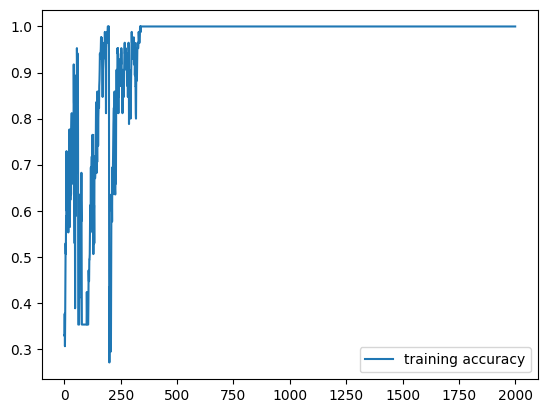

In [160]:
plt.plot(LSTM_model_history.history['categorical_accuracy'] , label = 'training accuracy')
plt.legend(loc ='lower right')

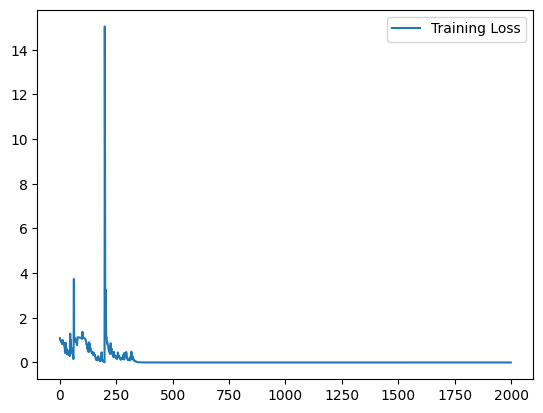

In [161]:
plt.plot(LSTM_model_history.history['loss'] , label = 'Training Loss')
plt.legend(loc = 'upper right')

In [162]:
LSTM_model.evaluate(X_test , y_test , verbose = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.8000 - loss: 2.7503


[2.7503490447998047, 0.800000011920929]

#### 3. Predicting Results

In [163]:
predictions = LSTM_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


In [169]:
predictions[0]

array([7.5290705e-16, 7.1340787e-09, 1.0000000e+00], dtype=float32)

In [173]:
actions[np.argmax(predictions[0])]

'iloveyou'

In [176]:
actions[np.argmax(y_test[0])]

'iloveyou'

In [177]:
results , actual = [] , []

for result in predictions:
  
  outcome = actions[np.argmax(result)]

  results.append(outcome)
  

for i in range(len(y_test)):

  act_out = actions[np.argmax(y_test[i])] 

  actual.append(act_out)


In [178]:
results

['iloveyou', 'hello', 'iloveyou', 'hello', 'iloveyou']

In [179]:
actual

['iloveyou', 'hello', 'hello', 'hello', 'iloveyou']